In [1]:
%pip -qq install mlflow==1.24 pillow sklearn kaggle

Note: you may need to restart the kernel to use updated packages.


# AIMaker 公用範本 - 圖片分類 (Image Classification)

##  簡介
AIMaker 針對圖像分類應用提供 **image-classification** 公用範本，能無程式碼建立一個圖像分類應用。
公用範本中定義了從訓練任務到推論任務中所需環境變數、映像檔、程式等設定，您只須上傳欲訓練或推論的資料集，並修改相關的設定，即可快速執行訓練與推論任務。

### 主要步驟如下：

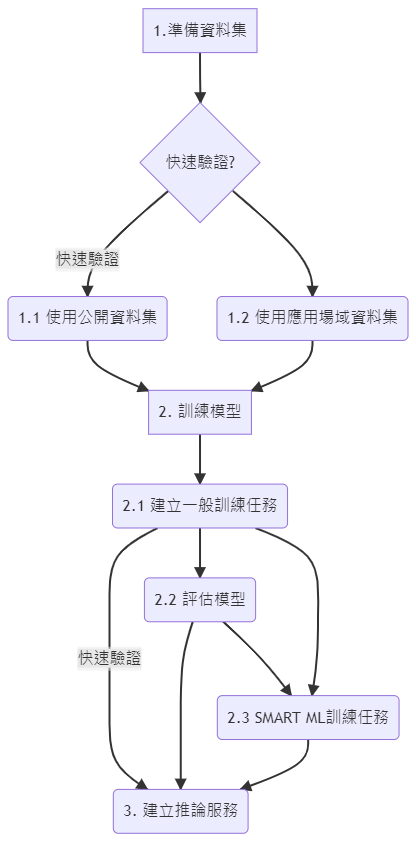

- **準備資料集**    
  在此階段，我們要著手準備要讓電腦學習的影像集，並將資料集上傳至指定位置。

- **訓練模型**  
  在此階段，我們將配置訓練任務，以進行神經網路的訓練與擬合，並將訓練好的模型儲存。

- **建立推論服務**  
  在此階段，我們會將儲存下來的模型部署到服務中，以執行推論。

In [2]:
'''---載入套件---'''
import os
import shutil
import mlflow
import ast
import numpy as np
import pandas as pd
import json
import urllib.request
from PIL import Image
from Utils import PrepareDataset
from IPython.display import HTML
from sklearn.utils import resample
from mlflow.tracking import MlflowClient

## 1. 準備資料集
此階段要準備要讓電腦學習的圖片集:
- 若想快速了解AIMake與公用範本效用，請參照 **1.1 使用公開資料集** 說明。
- 若想使用實際的場域資料，請參照 **1.2 使用應用場域資料集** 說明。

### 1.1 使用公開資料集
本章節所使用的資料集，是由 Alexander Mamaev 提供於 kaggle 的 [Flowers Recognition（花卉資料集）](https://www.kaggle.com/alxmamaev/flowers-recognition)，執行本章節程式前請先完成以下準備工作，並把資訊填入 **---參數設定---**

- 取得kaggle的API token:
  - 取得方式請參考[Kaggle's public API說明](https://github.com/Kaggle/kaggle-api#api-credentials)
    - 點選右上角的帳號圖示，開啟選單
    - 點選**Account**進入管理頁面
    - 往下找到**API**區塊，點選**Create New API Token**下載**kaggle.json**
  
     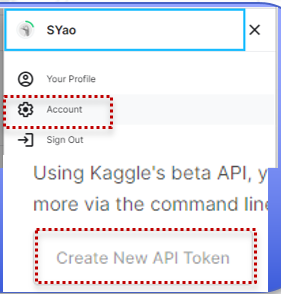
  - 將下載**kaggle.json**的內容填入下方的**KAGGLE_USERNAME**與**KAGGLE_KEY**參數
 
- 掛載存放資料集的**儲存體**
  1. 從OneAI選單點選**OneAI**->**儲存服務**->**建立**，建立一空的AIMaker儲存體，建立方式請參考[建立儲存服務](https://docs.oneai.twcc.ai/s/_F4C_EzEa#%E5%BB%BA%E7%AB%8B%E5%84%B2%E5%AD%98%E9%AB%94)
  1. **掛載**上步驟建立的**儲存體**到此筆記本，掛載路徑建議指定為 **/data** ，掛載方式請參考[設定筆記本服務的儲存資訊](https://docs.oneai.twcc.ai/s/Z8LdmjL9M#3-%E5%84%B2%E5%AD%98)
     - **注意:此動作會重啟此筆記本，執行前請存檔**
     - 開發框架請選擇**TensorFlow-21.02-tf2-py3**以利後續範例的執行
     - 若設定其他掛載路徑，請修改下方 **DATA_MOUNT_PATH** 參數
     
    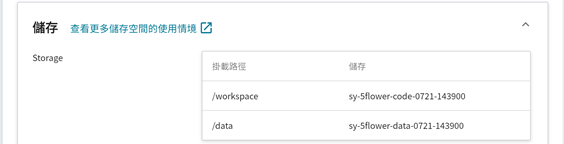

In [3]:
'''---參數設定---'''
os.environ["KAGGLE_USERNAME"] = "你的Kaggle帳號"
os.environ["KAGGLE_KEY"] = "你的Kaggle Key"
os.environ["DATA_MOUNT_PATH"] = "/data"

In [4]:
'''---使用kaggle API下載資料---'''
!kaggle datasets download -d alxmamaev/flowers-recognition -p {os.environ["DATA_MOUNT_PATH"]} --force

 97%|███████████████████████████████████████▊ | 218M/225M [00:02<00:00, 109MB/s]
100%|█████████████████████████████████████████| 225M/225M [00:02<00:00, 110MB/s]


In [5]:
%%time
'''---解壓縮資料---'''
!unzip -qo -d {os.environ["DATA_MOUNT_PATH"]} {os.environ["DATA_MOUNT_PATH"]}/flowers-recognition.zip 

CPU times: user 308 ms, sys: 79.7 ms, total: 388 ms
Wall time: 27.9 s


In [6]:
'''---取得資料集清單---'''
Dataset = {}
PrepareDataset.GetDataSetList(f"/{os.environ['DATA_MOUNT_PATH']}/flowers",Dataset)
print(f"資料類別:{Dataset.keys()}")

資料類別:dict_keys(['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'])


In [7]:
'''---分割資料集清單為訓練資料集(70%)與驗證資料集(30%)---'''
PrepareDataset.SplitDataSet(Dataset,RandomSeed = 721)
print(PrepareDataset.CountDataSet(Dataset))

類別	訓練資料量	測試資料量
daisy	534		230		
dandelion	736		316		
rose	548		236		
sunflower	513		220		
tulip	688		296		



In [8]:
%%time
'''---根據分割清單，複製檔案到對應的資料夾---'''
PrepareDataset.MakeTrainingDataSet(f"/{os.environ['DATA_MOUNT_PATH']}/flowers",Dataset)

CPU times: user 1.07 s, sys: 2.06 s, total: 3.13 s
Wall time: 4min 17s


In [11]:
'''---分析資料集分布---'''
!apt-get update
!apt-get -y install duc
!duc index {os.environ['DATA_MOUNT_PATH']}/dataset
!duc graph -a --count --gradient {os.environ['DATA_MOUNT_PATH']}/dataset

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://security.ubuntu.com/ubuntu focal-security InRelease
Get:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Fetched 222 kB in 2s (111 kB/s)  
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
duc is already the newest version (1.4.3-6).
0 upgraded, 0 newly installed, 0 to remove and 131 not upgraded.


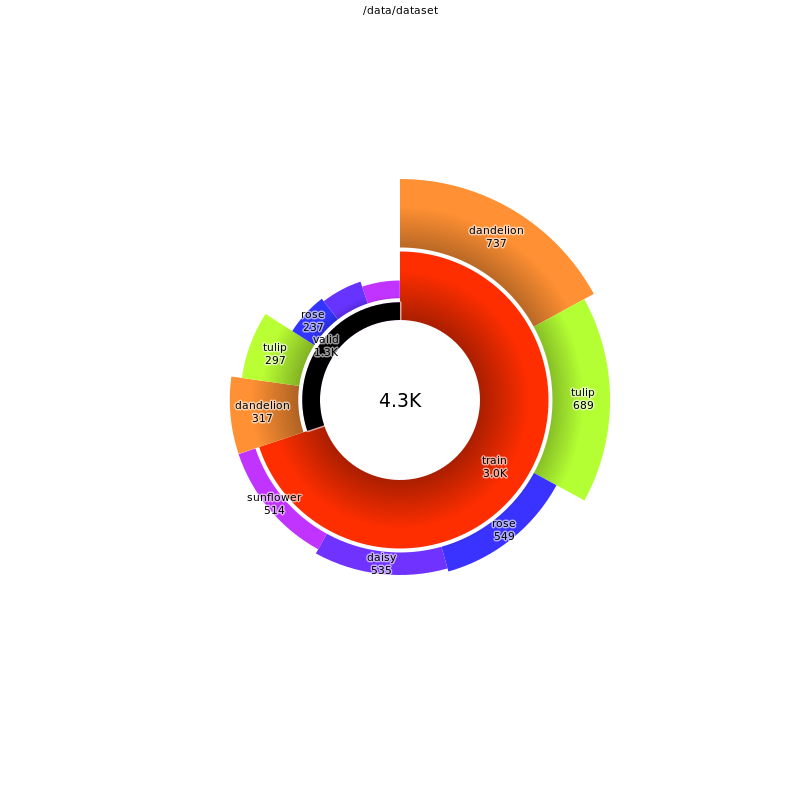

In [12]:
'''---視覺化顯示資料集分布---'''
display(Image.open("./duc.png"))

### 1.2 使用應用場域資料集
**image-classification 公用範本**要求訓練資料集依照以下的結構擺放，其中**dataset**、**train**、**valid**資料夾名稱需一致，若未符合結構要求，可透過本章節程式協助整理:
```
掛載路徑
└───dataset
│   └───train
│   │   └───類別1
│   │   │   │   image-11.jpg
│   │   │   │   image-12.jpg
│   │   │   │   ...
│   │   └───類別2
│   │   │   │   image-21.jpg
│   │   │   │   image-22.jpg
│   │   │   │   ...
│   │   └───...
│   └───valid
│   │   └───類別1
│   │   │   │   image-13.jpg
│   │   │   │   ...
│   │   └───類別2
│   │   │   │   image-23.jpg
│   │   │   │   ...
│   │   └───...

```

本章節將指導用戶上傳應用場域的資料集到平台，並做必要的整理。執行本章節程式前請先完成以下準備工作，並把資訊填入 **---參數設定---**

- 掛載存放資料集的**儲存體**
  1. 從OneAI選單點選**OneAI**->**儲存服務**->**建立**，建立一空的AIMaker儲存體，建立方式請參考[建立儲存服務](https://docs.oneai.twcc.ai/s/_F4C_EzEa#%E5%BB%BA%E7%AB%8B%E5%84%B2%E5%AD%98%E9%AB%94)
  1. 上傳資料集到上一步驟建立的空儲存體，上傳檔案方式請參考[上傳檔案](https://docs.oneai.twcc.ai/s/_F4C_EzEa#%E4%B8%8A%E5%82%B3%E6%AA%94%E6%A1%88)
     - 建議上傳前先將資料集壓縮，縮短上傳時間；若採壓縮方式上傳，請修改請修改下方**"DATA_ZIP_FILENAME"**參數。
     - 若未符合**image-classification 公用範本**資料集結構要求，可透過修改本章節程式協助整理。
     - 本章節程式假設用戶用資料夾來分類圖片類別，並將這些資料夾壓縮後上傳。
  1. **掛載**上步驟建立的**儲存體**到本筆記本，掛載路徑建議指定為 **/data** ，掛載方式請參考[設定筆記本服務的儲存資訊](https://docs.oneai.twcc.ai/s/Z8LdmjL9M#3-%E5%84%B2%E5%AD%98)
     - **注意:此動作會重啟此筆記本，執行前請存檔**。
     - 開發框架請選擇**TensorFlow-21.02-tf2-py3**以利後續範例的執行。
     - 若設定其他掛載路徑，請修改下方 **DATA_MOUNT_PATH** 參數。
     
    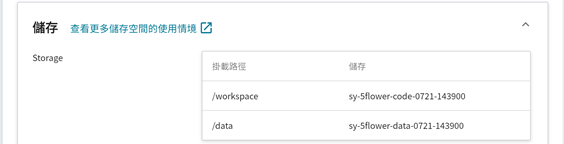

In [13]:
'''---參數設定---'''
os.environ["DATA_MOUNT_PATH"]="/data"
os.environ["DATA_ZIP_FILENAME"]="SurfaceCrack.zip"

In [14]:
%%time
'''---解壓縮資料---'''
if os.path.exists(f"/{os.environ['DATA_MOUNT_PATH']}/CustomUpload"):
    shutil.rmtree(f"/{os.environ['DATA_MOUNT_PATH']}/CustomUpload")
os.mkdir(f"/{os.environ['DATA_MOUNT_PATH']}/CustomUpload")
!unzip -qo -d {os.environ["DATA_MOUNT_PATH"]}/CustomUpload {os.environ["DATA_MOUNT_PATH"]}/{os.environ["DATA_ZIP_FILENAME"]}

CPU times: user 4.21 s, sys: 1.95 s, total: 6.16 s
Wall time: 7min 57s


In [15]:
'''---取得資料集清單---'''
Dataset = {}
PrepareDataset.GetDataSetList(f"/{os.environ['DATA_MOUNT_PATH']}/CustomUpload",Dataset)
print(f"資料類別:{Dataset.keys()}")

資料類別:dict_keys(['Negative', 'Positive'])


In [16]:
'''---分割資料集清單為訓練資料集(70%)與驗證資料集(30%)---'''
PrepareDataset.SplitDataSet(Dataset,RandomSeed = 721)
print(PrepareDataset.CountDataSet(Dataset))

類別	訓練資料量	測試資料量
Negative	14000		6000		
Positive	14000		6000		



In [17]:
%%time
'''---根據分割清單，複製檔案到對應的資料夾---'''
PrepareDataset.MakeTrainingDataSet(f"/{os.environ['DATA_MOUNT_PATH']}/CustomUpload",Dataset)

CPU times: user 4.2 s, sys: 6.88 s, total: 11.1 s
Wall time: 5min 7s


In [18]:
!apt-get update
!apt-get -y install duc
!duc index {os.environ['DATA_MOUNT_PATH']}/dataset
!duc graph -a --count --gradient {os.environ['DATA_MOUNT_PATH']}/dataset

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Fetched 114 kB in 1s (76.1 kB/s)                         
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
duc is already the newest version (1.4.3-6).
0 upgraded, 0 newly installed, 0 to remove and 131 not upgraded.


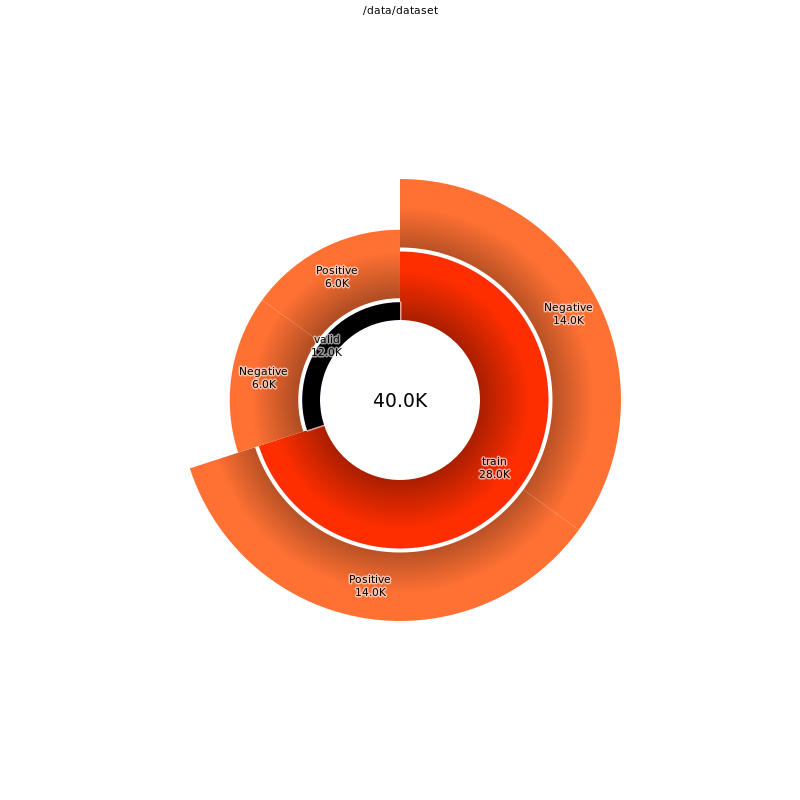

In [19]:
'''---視覺化顯示資料集分布---'''
display(Image.open("./duc.png"))

## 2. 訓練模型
此階段要用訓練任務來安排模型訓練:
- **2.1 建立一般訓練任務** 章節先用一般訓練任務 **驗證資料集能訓練出模型**。
- **2.2 評估模型** 章節將透此筆記載入訓練的模型來測試其預測效果。
- **2.3 建立SMART ML 訓練任務** 章節再用auto ML服務， **自動調整超參數** 來找尋最佳的模型。

### 2.1 建立一般訓練任務

執行本章節程式前請先完成以下準備工作，並把資訊填入 **---參數設定---**

- 用公用範本訓練模型
  - 從OneAI選單點選**OneAI**->**AIMakere (搶鮮版)**->**訓練任務**->**一般訓練任務**->**建立**，建立一訓練任務，建立方式請參考[建立訓練任務](https://docs.oneai.twcc.ai/s/QFn7N5R-H#%E5%BB%BA%E7%AB%8B%E8%A8%93%E7%B7%B4%E4%BB%BB%E5%8B%99)
    - 在**基本資訊**步驟中的**選擇範本**選項，選擇**image-classification**範本
    
    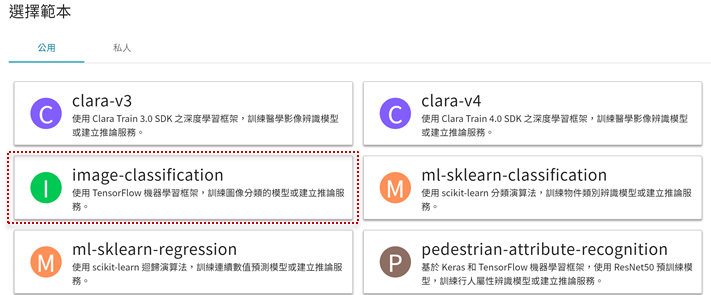
    - 在**儲存設定**步驟中的**輸入來源**選項，選擇章節**1. 準備資料集**建立的儲存體
    
    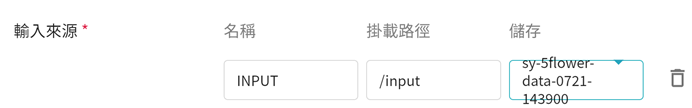
  - 點選UI上的**啟動**紐啟動訓練任務，啟動方式請參考[啟動訓練任務](https://docs.oneai.twcc.ai/tDQxeDD5RzO-ld_fxPQqwA?both#22-%E5%95%9F%E5%8B%95%E8%A8%93%E7%B7%B4%E4%BB%BB%E5%8B%99)
    - 透過**運行列表**了解訓練工作狀態
    
    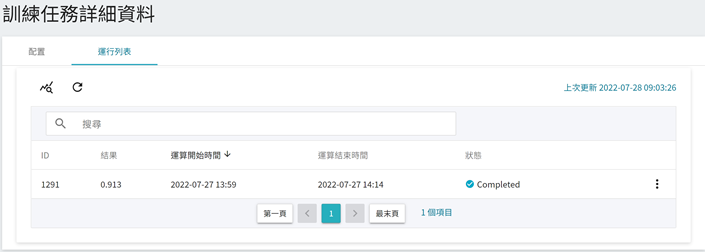
- 註冊模型
  - 點選**運行列表**上，狀態為**Completed**的訓練工作，開啟MLflow Tracking UI
  - 點選**Register Model**按鈕註冊模型
    - **Model**選擇**Create New Model**
    - 請將輸入的**Model Name**填入下方**MODEL_NAME**參數
    
    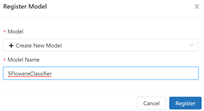
- 取得實驗追蹤Server資訊
  - 從OneAI選單點選**OneAI**->**AIMakere (搶鮮版) **->**MLflow追蹤**，複製變數設定，並覆蓋下方對應的**參數**
  
   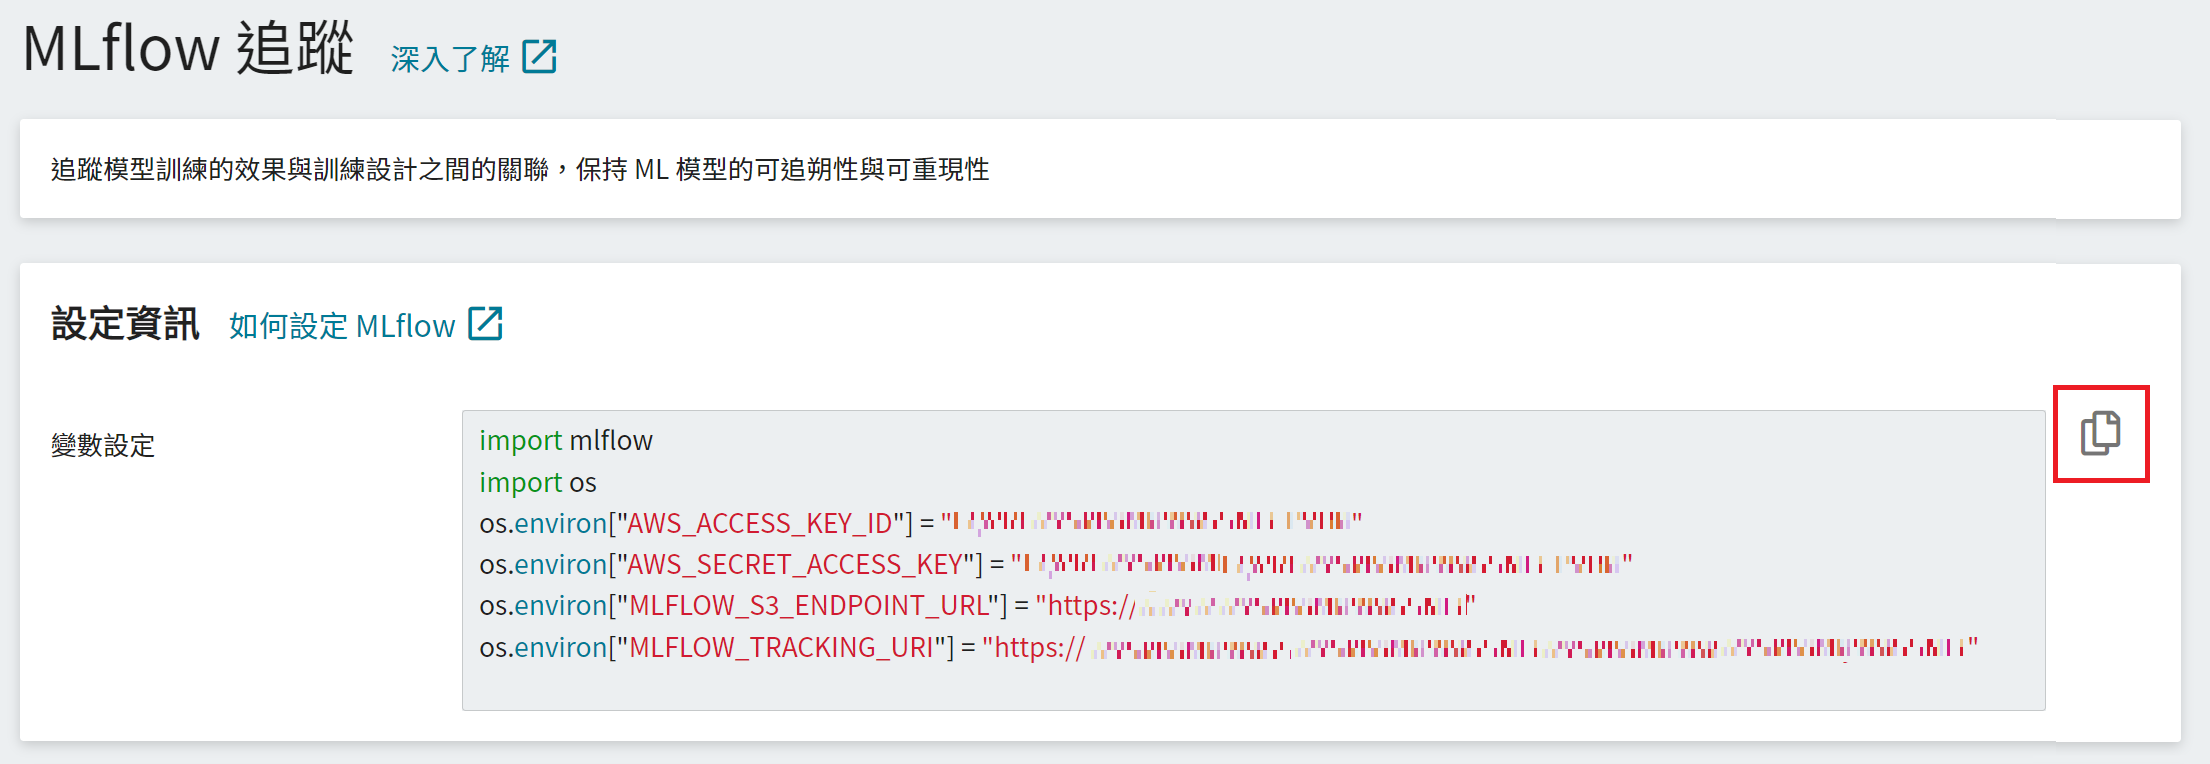

In [20]:
'''---參數設定---'''
os.environ["MODEL_NAME"] = "5FlowerClassifier"

os.environ["AWS_ACCESS_KEY_ID"] = "你的S3 ACCESS KEY ID"
os.environ["AWS_SECRET_ACCESS_KEY"] = "你的S3 SECRET ACCESS KEY ID"
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "你的S3 ENDPOINT URL"
os.environ["MLFLOW_TRACKING_URI"] = "你的MLflow TRACKING URI"

### 2.2 評估模型

本章節將從資料集中的驗證資料 **(/dataset/valid)** 中，各類別隨機挑8張圖片，評估**2.1 建立一般訓練任務**所訓練 & 註冊的模型效果。
- 執行本章節程式前，請確保已完成**2.1 建立一般訓練任務**工作

In [21]:
%%time
'''---載入最新版模型---'''
FlowerClassifier = mlflow.keras.load_model(f"models:/{os.environ['MODEL_NAME']}/latest")
FlowerClassifier

CPU times: user 32.9 s, sys: 5.52 s, total: 38.4 s
Wall time: 38.5 s


In [22]:
'''---載入模型資訊---'''
client = MlflowClient()
ModelInfo = client.get_registered_model(os.environ["MODEL_NAME"])
RunInfo = client.get_run(ModelInfo.latest_versions[0].run_id)
ImageSize = ast.literal_eval(RunInfo.data.tags['InputShape'])
ID2Label = ast.literal_eval(RunInfo.data.tags["IDandLabel"])
ClassMode = RunInfo.data.tags["ClassMode"]
ModelInfo

<RegisteredModel: creation_timestamp=1660115758006, description='', last_updated_timestamp=1660115758129, latest_versions=[<ModelVersion: creation_timestamp=1660115758129, current_stage='None', description='', last_updated_timestamp=1660115758129, name='SurfaceCrackClassifier', run_id='49b4428389714bc59668700ed8a3dd75', run_link='', source='s3://mlflow/8/49b4428389714bc59668700ed8a3dd75/artifacts/image_classifier_model', status='READY', status_message='', tags={}, user_id='', version='1'>], name='SurfaceCrackClassifier', tags={}>

In [23]:
'''---挑選驗證資料---'''
Dataset = {}
ValidResult = {}
ValidResult['Image'] = []
ValidResult['Label'] = []
ValidResult['Result'] = []
ValidTensor = []

for Path, Folders, Files in os.walk("/data/dataset/valid"):
    if (len(Files) > 0):
        FolderName = Path.split("/")[-1]
        Dataset[FolderName] = {}
        Dataset[FolderName]['FileList'] = Files

for FolderName in Dataset.keys():
    Dataset[FolderName]['Sample'] = resample(Dataset[FolderName]['FileList'], n_samples = 8)
    for FileName in Dataset[FolderName]['Sample']:
        ValidImage = Image.open(f"/data/dataset/valid/{FolderName}/{FileName}")
        ValidImage = ValidImage.resize(ImageSize[:2])
        ValidResult['Image'].append(ValidImage)
        ValidResult['Label'].append(FolderName)
        ValidImage = np.array(ValidImage).astype(np.float32)
        ValidTensor.append(ValidImage)

CPU times: user 6.98 s, sys: 148 ms, total: 7.13 s
Wall time: 4.95 s


,Image,Label,Result,Negative,Positive
0,,Negative,Negative,9.999491e-01,5.089781e-05
1,,Negative,Negative,9.999950e-01,4.960483e-06
2,,Negative,Negative,9.999826e-01,1.740971e-05
3,,Negative,Negative,9.997908e-01,2.091527e-04
4,,Negative,Negative,9.999997e-01,2.523912e-07
5,,Negative,Negative,9.999897e-01,1.027815e-05
6,,Negative,Negative,9.999979e-01,2.064428e-06
7,,Negative,Negative,9.999600e-01,4.002256e-05
8,,Positive,Positive,2.384186e-07,9.999998e-01
9,,Positive,Positive,0.000000e+00,1.000000e+00

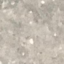
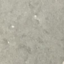
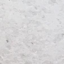
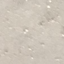
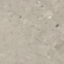
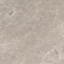
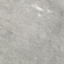
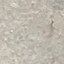
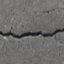
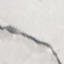
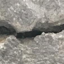
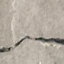
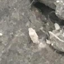
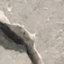
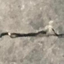
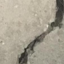

In [24]:
%%time
'''---推論---'''
AllScores = FlowerClassifier.predict(np.array(ValidTensor))
NewScores=[]

for Scores in AllScores :
    if (ClassMode == 'binary'):
        ValidResult['Result'].append(ID2Label[1 if Scores >= 0.5 else 0])
        NewScores.append([1-Scores[0],Scores[0]])
    else:
        MaxScore = max(Scores)
        ValidResult['Result'].append(ID2Label[list(Scores).index(MaxScore)])
ResultDF = pd.DataFrame(ValidResult)
if (ClassMode == 'binary'):
    ResultDF[list(ID2Label.values())] = NewScores
else:
    ResultDF[list(ID2Label.values())] = AllScores
ResultDF.head(3)
HTML(ResultDF.to_html(formatters = {"Image": PrepareDataset.FormateImage}, escape=False))

### 2.3 建立SMART ML 訓練任務

執行本章節程式前請先完成以下準備工作，並把資訊填入 **---參數設定---**

- 用公用範本訓練模型
  - 從OneAI選單點選**OneAI**->**AIMakere (搶鮮版) **->**訓練任務**->**SMART ML 訓練任務**->**建立**，建立一訓練任務，建立方式請參考[建立訓練任務](https://docs.oneai.twcc.ai/s/QFn7N5R-H#%E5%BB%BA%E7%AB%8B%E8%A8%93%E7%B7%B4%E4%BB%BB%E5%8B%99)
    - [option]在**基本資訊**步驟中的**MLflow Experiment**選項，選擇**綁定存在的MLflow Experiment**
      - 綁定後，可以讓不同的訓練任務結果匯集在一起，以利後續分析
      - 建議挑選**2.1 建立一般訓練任務**建立的MLflow Experiment，名稱可從**訓練任務詳細資料**查詢
      
      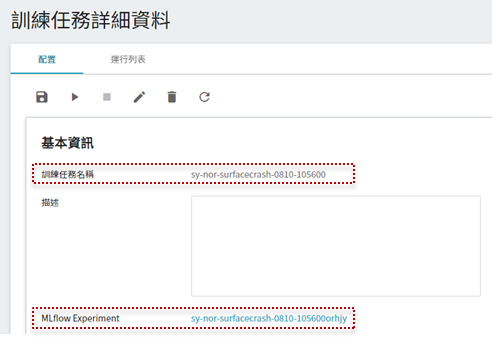
    - 在**基本資訊**步驟中的**選擇範本**選項，選擇**image-classification**範本
    
      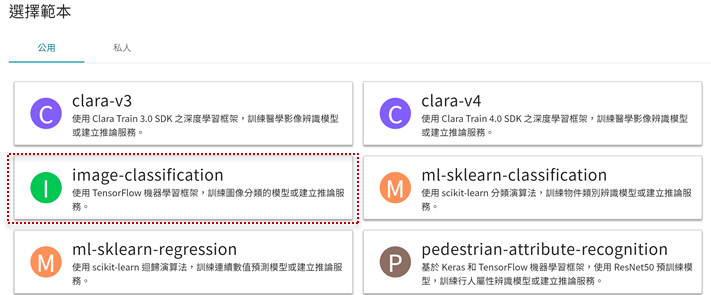
    - 在**儲存設定**步驟中的**輸入來源**選項，選擇章節**1. 準備資料集**建立的儲存體
    
      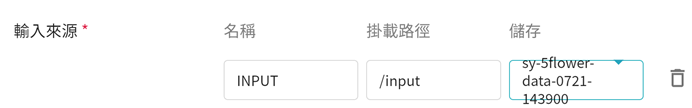
     - [option]在**變數設定**步驟中的**超參數**選項，點選**新增**增加一類型為**列表**的超參數，名稱填入**PRETRAIN_MODEL**，數值填入**ResNet50,Xception,VGG16,DenseNet121,InceptionV3,InceptionResNetV2,MobileNetV2**
     
      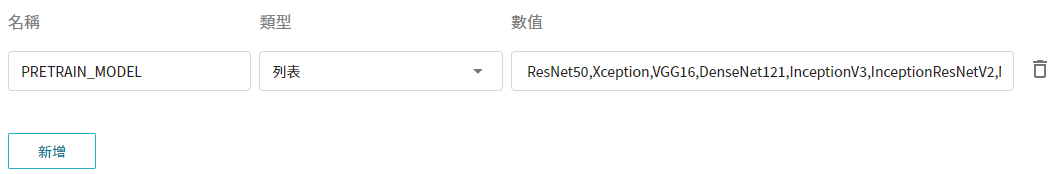
      
      - [option]在**變數設定**步驟中的**任務次數**選項，修改訓練工作執行的次數
     
  - 點選UI上的**啟動**紐啟動訓練任務，啟動方式請參考[啟動訓練任務](https://docs.oneai.twcc.ai/tDQxeDD5RzO-ld_fxPQqwA?both#22-%E5%95%9F%E5%8B%95%E8%A8%93%E7%B7%B4%E4%BB%BB%E5%8B%99)
    - 透過**運行列表**了解訓練工作狀態
    
      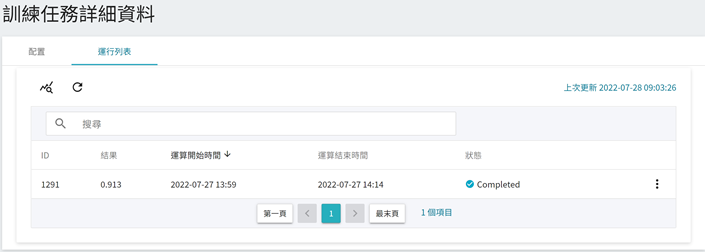
- 註冊模型
  - 點選**運行列表**上，狀態為**Completed**的訓練工作，開啟MLflow Tracking UI
  - 點選**Register Model**按鈕註冊模型
    - **Model**選擇**2.1 建立一般訓練任務**建立的模型
    
    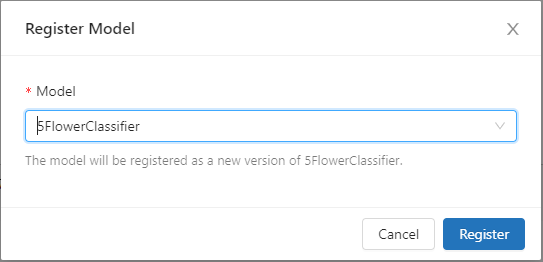
- [option]評估模型
  - 再次執行**2.2 評估模型**章節的程式，評估透過SMART ML訓練的模型效果

## 3. 建立推論服務
此階段要用**容器服務**建立推論服務，請先執行下方程式取得前面章節設定的資訊:

In [ ]:
'''---取得前章節設定的參數---'''
print(f"AWS_ACCESS_KEY_ID = {os.environ['AWS_ACCESS_KEY_ID']}")
print(f"AWS_SECRET_ACCESS_KEY = {os.environ['AWS_SECRET_ACCESS_KEY']}")
print(f"MLFLOW_S3_ENDPOINT_URL = {os.environ['MLFLOW_S3_ENDPOINT_URL']}")
print(f"MLFLOW_TRACKING_URI = {os.environ['MLFLOW_TRACKING_URI']}")
print(f"MODEL_NAME = {os.environ['MODEL_NAME']}")


執行本章節程式前請先完成以下準備工作，並把資訊填入 **---參數設定---**
     
- 用容器服務建立推論服務
  - 從OneAI選單點選**OneAI**->**AIMakere (搶鮮版)**->**容器服務**->**建立**，建立一容器，建立方式請參考[建立容器服務](https://docs.oneai.twcc.ai/s/yGbG4JJyi#%E5%BB%BA%E7%AB%8B%E5%AE%B9%E5%99%A8%E6%9C%8D%E5%8B%99)
    - 在**基本資訊**步驟中的**映像檔來源**選項，選擇**image-classification**映像檔
    
      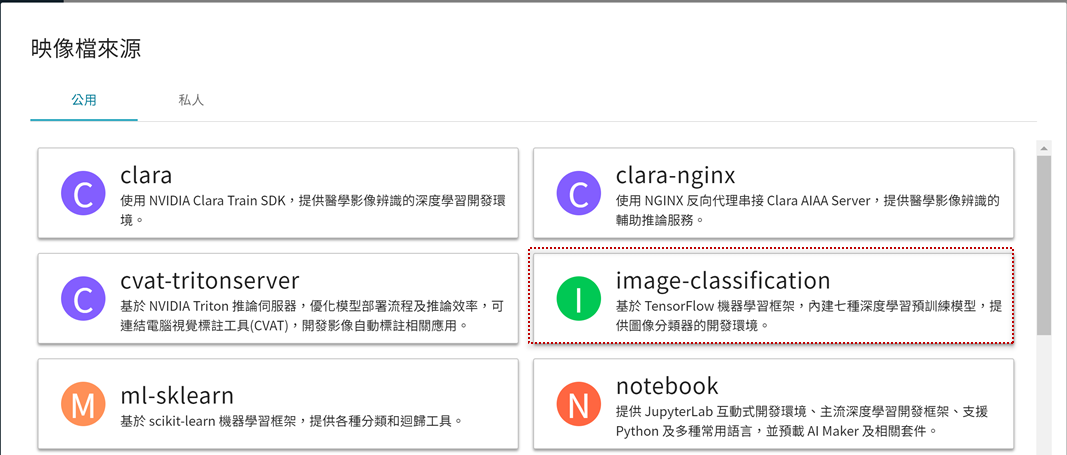
      
    - [option]在**硬體設定**步驟中，挑選含GPU的Flavor
    - 在**網路設定**步驟中的**配置容器網路設定**選項，點選**新增**，並填入以下數值:
      - **容器連接埠**填入5000，若變更此數值，請修改下方 **INFERENCE_PORT** 參數
      - **對外服務**選擇**Auto Generation**
      - **服務協定**選擇**TCP**
      
        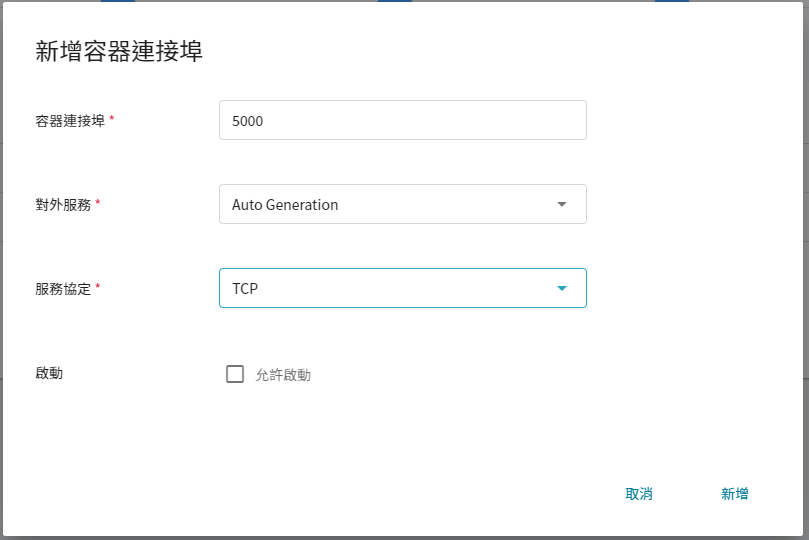
    - 在**變數設定**步驟中的**環境變數**選項，點選**新增**4個欄位，並填入**上一段程式輸出**對應的數值:
      - **AWS_ACCESS_KEY_ID**填入```AWS_ACCESS_KEY_ID  =```後的內容
      - **AWS_SECRET_ACCESS_KEY**填入```AWS_SECRET_ACCESS_KEY =```後的內容
      - **MLFLOW_S3_ENDPOINT_URL**填入```MLFLOW_S3_ENDPOINT_URL =```後的內容
      - **MLFLOW_TRACKING_URI**填入```MLFLOW_TRACKING_URI =```後的內容
    - 在**變數設定**步驟中的**命令**選項，填入: ```mlflow models serve -m "models:/{模型名稱}/latest" -p {容器連接埠} -h 0.0.0.0 --no-conda```
      - **{模型名稱}** 填入**上一段程式輸出**中```MODEL_NAME =```後的內容
      - **{容器連接埠}** 填入下方 **INFERENCE_PORT** 參數設定的數值
      - 參考輸入: ```mlflow models serve -m "models:/5FlowerClassifier/latest" -p 5000 -h 0.0.0.0 --no-conda```
    
      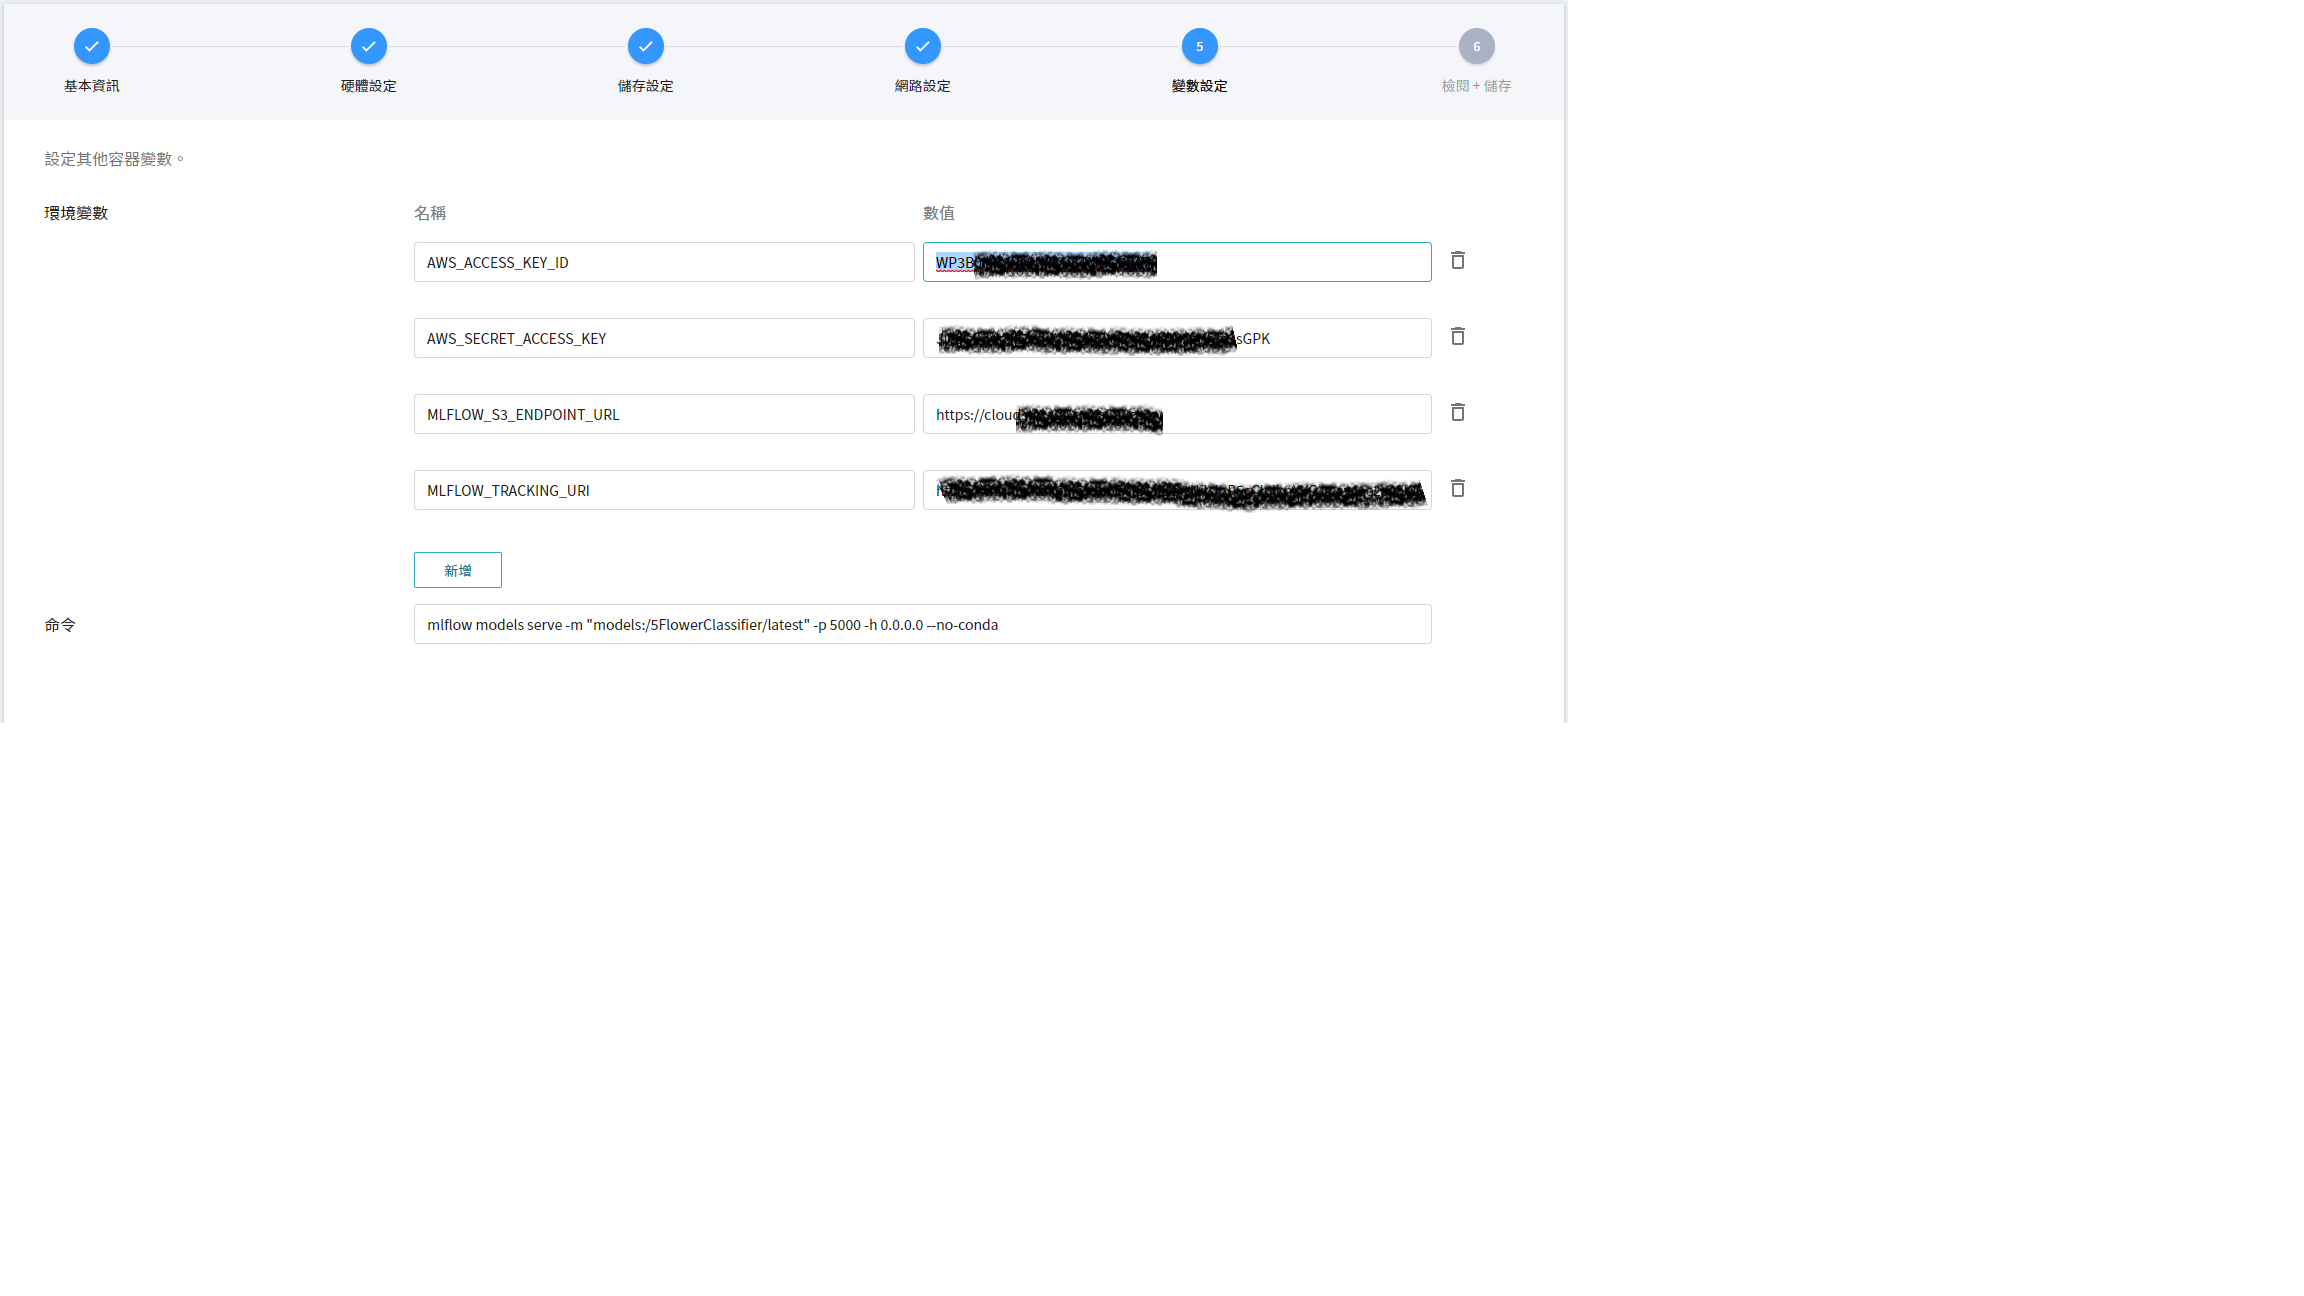
  - 取得推論對外的連接埠
    - 點選剛建立的容器，**從容器服務詳細資料**頁面中的**網路**，取得**DNS名稱**，並將內容填入下方 **INFERENCE_URL** 參數
      
      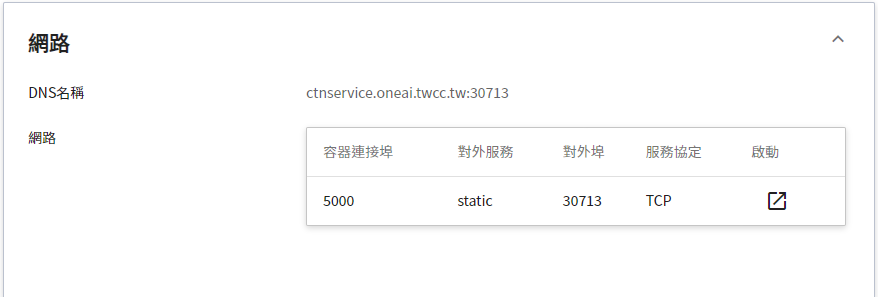

In [26]:
'''---參數設定---'''
os.environ["INFERENCE_PORT"] = "5000"
os.environ["INFERENCE_URL"] = "ctnservice.oneai.twcc.tw:30713"

In [27]:
'''---載入模型資訊---'''
client = MlflowClient()
ModelInfo = client.get_registered_model(os.environ["MODEL_NAME"])
RunInfo = client.get_run(ModelInfo.latest_versions[0].run_id)
ImageSize = ast.literal_eval(RunInfo.data.tags['InputShape'])
ID2Label = ast.literal_eval(RunInfo.data.tags["IDandLabel"])
ClassMode = RunInfo.data.tags["ClassMode"]
ModelInfo

<RegisteredModel: creation_timestamp=1660115758006, description='', last_updated_timestamp=1660115758129, latest_versions=[<ModelVersion: creation_timestamp=1660115758129, current_stage='None', description='', last_updated_timestamp=1660115758129, name='SurfaceCrackClassifier', run_id='49b4428389714bc59668700ed8a3dd75', run_link='', source='s3://mlflow/8/49b4428389714bc59668700ed8a3dd75/artifacts/image_classifier_model', status='READY', status_message='', tags={}, user_id='', version='1'>], name='SurfaceCrackClassifier', tags={}>

In [28]:
'''---挑選驗證資料---'''
Dataset = {}
ValidResult = {}
ValidResult['Image'] = []
ValidResult['Label'] = []
ValidResult['Result'] = []
ValidTensor = []

for Path, Folders, Files in os.walk("/data/dataset/valid"):
    if (len(Files) > 0):
        FolderName = Path.split("/")[-1]
        Dataset[FolderName] = {}
        Dataset[FolderName]['FileList'] = Files

for FolderName in Dataset.keys():
    Dataset[FolderName]['Sample'] = resample(Dataset[FolderName]['FileList'], n_samples = 8)
    for FileName in Dataset[FolderName]['Sample']:
        ValidImage = Image.open(f"/data/dataset/valid/{FolderName}/{FileName}")
        ValidImage = ValidImage.resize(ImageSize[:2])
        ValidResult['Image'].append(ValidImage)
        ValidResult['Label'].append(FolderName)
        ValidImage = np.array(ValidImage).astype(np.float32)
        ValidTensor.append(ValidImage)

CPU times: user 1.61 s, sys: 141 ms, total: 1.75 s
Wall time: 3.76 s


,Image,Label,Result,Negative,Positive
0,,Negative,Negative,9.999817e-01,0.000018
1,,Negative,Negative,9.999956e-01,0.000004
2,,Negative,Negative,9.999456e-01,0.000054
3,,Negative,Negative,9.998693e-01,0.000131
4,,Negative,Negative,9.981743e-01,0.001826
5,,Negative,Negative,9.998604e-01,0.000140
6,,Negative,Negative,9.999500e-01,0.000050
7,,Negative,Negative,9.998368e-01,0.000163
8,,Positive,Positive,8.451939e-05,0.999915
9,,Positive,Positive,0.000000e+00,1.000000

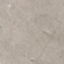
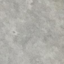
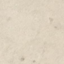
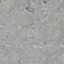
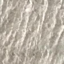
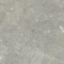
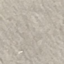
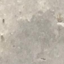
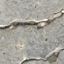
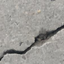
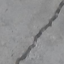
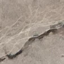
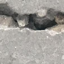
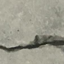
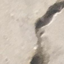
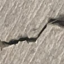

In [29]:
%%time
'''---推論---'''
Url=f"http://{os.environ['INFERENCE_URL']}/invocations"
Headers = {'Content-Type':'application/json'}
Data = {
    "instances": np.array(ValidTensor).tolist()
}
Body = str.encode(json.dumps(Data))

Req = urllib.request.Request(Url, Body, Headers)
try:
    Response = urllib.request.urlopen(Req)
    Result = Response.read()
    ResultJS=json.loads(Result)
    NewScores=[]
    for Scores in ResultJS :
        if (ClassMode == 'binary'):
            ValidResult['Result'].append(ID2Label[1 if Scores[0] >= 0.5 else 0])
            NewScores.append([1-Scores[0],Scores[0]])
        else:
            MaxScore = max(Scores)
            ValidResult['Result'].append(ID2Label[list(Scores).index(MaxScore)])
        
    ResultDF = pd.DataFrame(ValidResult)
    if (ClassMode == 'binary'):
        ResultDF[list(ID2Label.values())] = NewScores
    else:
        ResultDF[list(ID2Label.values())] = ResultJS
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))
    print(error.info())
    print(json.loads(error.read().decode("utf8", 'ignore')))
HTML(ResultDF.to_html(formatters = {"Image": PrepareDataset.FormateImage}, escape=False))